In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [140]:
import pandas as pd

ratings_url = 'https://drive.google.com/uc?export=download&id=1Fy2L9YRBiCT0738yIhpoJVOSXmD4Gt0I'
movies_url = 'https://drive.google.com/uc?export=download&id=1mItKOI2bO7DRhrZqiF2WBsarc34vZqeM'
counties_url = 'https://drive.google.com/uc?export=download&id=1mn1xdrqU6jeXhSuM4G2ooCL3LYHsiCnX'

# Load data
ratings = pd.read_csv(ratings_url, sep='\t', encoding='latin-1', usecols=['user_id', 'movie_id', 'user_emb_id', 'movie_emb_id', 'rating'])
movies = pd.read_csv(movies_url, sep='\t', encoding='latin-1', usecols=['movie_id', 'title', 'genres'])
countries_df = pd.read_csv(counties_url, sep=',', encoding='latin-1')

In [5]:
movies.head(5)

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
ratings.head(5)

,user_id,movie_id,rating,user_emb_id,movie_emb_id
0,1,1193,5,0,1192
1,1,661,3,0,660
2,1,914,3,0,913
3,1,3408,4,0,3407
4,1,2355,5,0,2354


In [141]:
countries_df.head()

,URL,United States,China,India,Japan,Brazil,Russia,Indonesia,Germany,United Kingdom,France
0,url_1,657,194,310,790,768,436,189,973,448,335
1,url_2,389,149,354,729,629,937,345,967,764,104
2,url_3,979,475,509,769,270,705,113,931,977,213
3,url_4,524,699,692,694,473,160,484,37,956,899
4,url_5,767,661,319,572,399,401,277,596,631,203


### Content Based

**Objective**: Build a Content-Based Recommendation system that computes similarity between movies based on movie genres. It will suggest movies that are most similar to a particular movie based on its genre.

**Dataset**:
- **Movies Data**: DataFrame with columns `movie_id`, `title`, and `genres`.

**Steps**:

1. **Preprocess Data**:
   - Split the `genres` column into separate genre strings.
   - Fill any missing values in the `genres` column and convert it to string.

2. **Compute TF-IDF Matrix**:
   - Use `TfidfVectorizer` to transform the genres into a TF-IDF matrix.

3. **Calculate Cosine Similarity**:
   - Compute cosine similarity between the TF-IDF matrices of movies.

4. **Recommend Movies**:
   - Create a function that gets movie recommendations based on the cosine similarity score of movie genres.

In [7]:
movies['genres'] = movies['genres'].str.split('|')
movies['genres'] = movies['genres'].fillna("").astype('str')

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(movies['genres'])

In [9]:
from sklearn.metrics.pairwise import linear_kernel

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [10]:
def genre_recommendations(title, n=10):
    idx = movies.index[movies['title'] == title].tolist()[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n+1]
    movie_indices = [i[0] for i in sim_scores]
    return movies['title'].iloc[movie_indices].tolist()

In [11]:
# Example
genre_recommendations('GoldenEye (1995)')

['Clear and Present Danger (1994)',
 'Surviving the Game (1994)',
 'Rock, The (1996)',
 'Daylight (1996)',
 'Chain Reaction (1996)',
 'Maximum Risk (1996)',
 'Anaconda (1997)',
 'Con Air (1997)',
 'Firestorm (1998)',
 'Perfect Storm, The (2000)']


### Collaborative Filtering

**Objective**: Implement a collaborative filtering movie recommendation system to recommend movies to a user based on similar users' spreferences.

**Dataset**:

- **Ratings Data**: DataFrame with columns `user_id`, `movie_id`, and `rating`.
- **Movies Data**: DataFrame with columns `movie_id`, `title`, and `genres`.

**Steps**:

1. **Preprocess Data**:
   - Merge `ratings` and `movies` DataFrames on `movie_id`.
   - Split `genres` column into separate rows.

2. **Create User-Genre Matrix**:
   - Create a matrix where rows are users and columns are genres.
   - Each cell represents the ratio of movies watched by the user in that genre to the total movies watched by the user.

3. **Calculate User Similarity**:
   - Use cosine similarity to calculate the similarity between users.

4. **Find Top N Similar Users**:
   - Find the top N users with the most similar preferences to the given user.

5. **Recommend Movies**:
   - Recommend movies that similar users have watched but the target user has not.
   - Return titles and genres of the top 10 recommended movies.

In [12]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [13]:
data = pd.merge(ratings, movies, on='movie_id')

In [14]:
data.head(5)

,user_id,movie_id,rating,user_emb_id,movie_emb_id,title,genres
0,1,1193,5,0,1192,One Flew Over the Cuckoo's Nest (1975),['Drama']
1,1,661,3,0,660,James and the Giant Peach (1996),"['Animation', ""Children's"", 'Musical']"
2,1,914,3,0,913,My Fair Lady (1964),"['Musical', 'Romance']"
3,1,3408,4,0,3407,Erin Brockovich (2000),['Drama']
4,1,2355,5,0,2354,"Bug's Life, A (1998)","['Animation', ""Children's"", 'Comedy']"


In [15]:
data = data.assign(genres=data['genres'].str.split('|')).explode('genres')

In [16]:
data.head(5)

,user_id,movie_id,rating,user_emb_id,movie_emb_id,title,genres
0,1,1193,5,0,1192,One Flew Over the Cuckoo's Nest (1975),['Drama']
1,1,661,3,0,660,James and the Giant Peach (1996),"['Animation', ""Children's"", 'Musical']"
2,1,914,3,0,913,My Fair Lady (1964),"['Musical', 'Romance']"
3,1,3408,4,0,3407,Erin Brockovich (2000),['Drama']
4,1,2355,5,0,2354,"Bug's Life, A (1998)","['Animation', ""Children's"", 'Comedy']"


In [17]:
def create_user_genre_matrix(data):
    user_genre_matrix = data.pivot_table(index='user_id', columns='genres', aggfunc='size', fill_value=0)
    user_genre_matrix = user_genre_matrix.div(user_genre_matrix.sum(axis=1), axis=0)
    return user_genre_matrix

In [32]:
user_genre_matrix = create_user_genre_matrix(data)
user_similarity = cosine_similarity(user_genre_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=user_genre_matrix.index, columns=user_genre_matrix.index)
user_similarity_df.head(5)

user_id,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
user_id,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.700616,0.263790,0.198349,0.746013,0.335790,0.034934,0.740531,0.768105,0.606995,...,0.599871,0.673598,0.192453,0.076218,0.596091,0.776295,0.709905,0.369019,0.428513,0.778642
2,0.700616,1.000000,0.234946,0.368718,0.885277,0.335986,0.370861,0.916273,0.890188,0.580996,...,0.659786,0.613919,0.491021,0.059787,0.688939,0.865308,0.818279,0.466579,0.318475,0.869229
3,0.263790,0.234946,1.000000,0.140733,0.447572,0.315127,0.063454,0.135451,0.350350,0.747341,...,0.618521,0.591616,0.191998,0.284297,0.637298,0.463486,0.376910,0.463023,0.551533,0.421064
4,0.198349,0.368718,0.140733,1.000000,0.239809,0.093633,0.521854,0.267352,0.245873,0.190546,...,0.312400,0.173916,0.592403,0.000000,0.231132,0.262354,0.237899,0.116052,0.073389,0.239081
5,0.746013,0.885277,0.447572,0.239809,1.000000,0.393560,0.151057,0.885451,0.937112,0.788511,...,0.774966,0.792514,0.291992,0.167262,0.850973,0.965926,0.890352,0.618813,0.478289,0.963891


In [36]:
def get_top_n_similar_users(user_id, n=5):
    if user_id not in user_similarity_df.index:
        return []
    sim_scores = user_similarity_df[user_id].sort_values(ascending=False)
    top_n_users = sim_scores.iloc[1:n+1] # not user_id
    return top_n_users.index.tolist()

In [37]:
def recommend_movies(user_id, n_similar_users=5, n_recommendations=10):
    similar_users = get_top_n_similar_users(user_id, n_similar_users)
    similar_users_movies = data[data['user_id'].isin(similar_users)]
    watched_movies = data[data['user_id'] == user_id]['movie_id'].unique()
    recommended_movies = similar_users_movies[~similar_users_movies['movie_id'].isin(watched_movies)]
    top_recommended_movies = recommended_movies['movie_id'].value_counts().head(n_recommendations).index
    top_recommended_movies_details = movies[movies['movie_id'].isin(top_recommended_movies)]
    return top_recommended_movies_details[['title', 'genres']]

In [52]:
# Example
user_id = 1
recommended_movies = recommend_movies(user_id, n_similar_users=6, n_recommendations=10)

In [53]:
recommended_movies

,title,genres
33,Babe (1995),"[""Children's"", 'Comedy', 'Drama']"
589,"Silence of the Lambs, The (1991)","['Drama', 'Thriller']"
1019,Alice in Wonderland (1951),"['Animation', ""Children's"", 'Musical']"
1499,Shall We Dance? (Shall We Dansu?) (1996),['Comedy']
1656,Good Will Hunting (1997),['Drama']
2018,Peter Pan (1953),"['Animation', ""Children's"", 'Fantasy', 'Musical']"
2027,Sleeping Beauty (1959),"['Animation', ""Children's"", 'Musical']"
2530,Election (1999),['Comedy']
2789,American Beauty (1999),"['Comedy', 'Drama']"
3091,Magnolia (1999),['Drama']


### SVD (Singular Value Decomposition)



**Objective**: Implement an SVD-based recommendation system to recommend movies to users by decomposing the user-item interaction matrix into latent factors.

**Dataset**:
- **Ratings Data**: DataFrame with columns `user_id`, `movie_id`, and `rating`.
- **Movies Data**: DataFrame with columns `movie_id`, `title`, and `genres`.

**Steps**:

1. **Preprocess Data**:
   - Merge `ratings` and `movies` DataFrames on `movie_id`.
   - Create a user-item matrix where rows represent users, columns represent movies, and the values are the ratings.

2. **Decompose Matrix using SVD**:
   - Apply Singular Value Decomposition (SVD) to decompose the user-item matrix into three matrices: $U$, $\Sigma$, and $V^T$.

3. **Reconstruct Matrix**:
   - Reconstruct the user-item matrix using the top $k$ singular values to reduce dimensionality.

4. **Predict Ratings**:
   - Use the reconstructed matrix to predict ratings for all user-item pairs.

5. **Recommend Movies**:
   - Recommend the top 20 movies with the highest predicted ratings for a given user that the user hasn't rated yet.

In [54]:
n_users = ratings.user_id.unique().shape[0]
n_movies = ratings.movie_id.unique().shape[0]
print('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_movies))

Number of users = 6040 | Number of movies = 3706


Fill na elements.

In [55]:
Ratings = ratings.pivot(index = 'user_id', columns ='movie_id', values = 'rating').fillna(0)
Ratings.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# calculate rating matrix

In [58]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(Ratings.to_numpy(), k=100)
sigma = np.diag(sigma)

In [59]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)

In [60]:
preds = pd.DataFrame(all_user_predicted_ratings, columns=Ratings.columns)
preds.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
0,5.132589,0.168593,0.354256,-0.025984,0.146412,-0.124057,-0.061609,0.079215,0.025162,-0.364816,...,-0.102774,0.008839,0.028378,-0.096139,-0.042566,0.007125,-0.112891,0.017840,0.081946,-0.192445
1,0.527079,0.278227,0.076380,-0.021186,0.036919,1.129623,-0.053878,0.119751,0.095301,1.710964,...,0.004399,-0.010270,-0.021023,0.078350,-0.008892,-0.431597,-0.238003,-0.008461,0.035765,0.036354
2,2.158835,0.384824,0.298305,-0.117883,-0.003051,0.096564,-0.008272,0.074512,-0.009878,1.075564,...,0.053171,0.007187,0.042976,0.069483,0.040690,0.014647,0.173379,0.076715,0.047036,-0.239905
3,0.170102,0.139338,0.049499,0.040963,-0.008043,0.282204,-0.054760,-0.003053,0.011237,-0.416429,...,-0.048642,-0.003518,0.013642,-0.002003,-0.031724,-0.185492,0.015460,-0.036204,-0.009392,-0.129042
4,0.374352,-0.418232,-0.022549,0.160691,-0.242144,1.526043,-0.135583,-0.071767,-0.139569,0.070673,...,0.026708,0.018442,-0.039586,-0.114310,-0.129007,-0.562672,0.229044,-0.085522,0.075491,0.013107


In [89]:
def recommend_movies(predictions, userID, movies, original_ratings, num_recommendations):
    user_row_number = userID - 1

    sorted_user_predictions = pd.DataFrame(predictions.iloc[user_row_number].sort_values(ascending=False))
    sorted_user_predictions.columns = ['Predictions']

    user_data = original_ratings[original_ratings['user_id'] == userID]

    user_full = user_data.merge(movies, how='left', on='movie_id').sort_values(['rating'], ascending=False)

    print(f'User {userID} has already rated {user_full.shape[0]} movies.')
    print(f'Recommending highest {num_recommendations} predicted ratings movies not already rated.')

    recommendations = (movies[~movies['movie_id'].isin(user_full['movie_id'])]
                       .merge(sorted_user_predictions, how='left', left_on='movie_id', right_index=True)
                       .sort_values('Predictions', ascending=False)
                       .iloc[:num_recommendations])

    return user_full, recommendations

In [90]:
already_rated, predictions = recommend_movies(preds, 4375, movies, ratings, 20)

User 4375 has already rated 325 movies.
Recommending highest 20 predicted ratings movies not already rated.


In [91]:
ratings.head(20)

,user_id,movie_id,rating,user_emb_id,movie_emb_id
0,1,1193,5,0,1192
1,1,661,3,0,660
2,1,914,3,0,913
3,1,3408,4,0,3407
4,1,2355,5,0,2354
5,1,1197,3,0,1196
6,1,1287,5,0,1286
7,1,2804,5,0,2803
8,1,594,4,0,593
9,1,919,4,0,918


In [ ]:
# Top 20 movies that User 4375 has rated
already_rated.head(20)

,user_id,movie_id,rating,user_emb_id,movie_emb_id,title,genres
195,4375,3250,5,4374,3249,Alive (1993),['Drama']
285,4375,175,5,4374,174,Kids (1995),['Drama']
199,4375,3257,5,4374,3256,"Bodyguard, The (1992)","['Action', 'Drama', 'Romance', 'Thriller']"
65,4375,3809,5,4374,3808,What About Bob? (1991),['Comedy']
210,4375,2688,5,4374,2687,"General's Daughter, The (1999)","['Drama', 'Thriller']"
270,4375,150,5,4374,149,Apollo 13 (1995),['Drama']
271,4375,2710,5,4374,2709,"Blair Witch Project, The (1999)",['Horror']
125,4375,349,5,4374,348,Clear and Present Danger (1994),"['Action', 'Adventure', 'Thriller']"
60,4375,288,5,4374,287,Natural Born Killers (1994),"['Action', 'Thriller']"
141,4375,47,5,4374,46,Seven (Se7en) (1995),"['Crime', 'Thriller']"


#### Evaluation

In [94]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)

train_ratings = train_data.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
R_train = train_ratings.values
user_ratings_mean_train = np.mean(R_train, axis=1)
Ratings_demeaned_train = R_train - user_ratings_mean_train.reshape(-1, 1)

U_train, sigma_train, Vt_train = svds(Ratings_demeaned_train, k=50)
sigma_train = np.diag(sigma_train)

all_user_predicted_ratings_train = np.dot(np.dot(U_train, sigma_train), Vt_train) + user_ratings_mean_train.reshape(-1, 1)
preds_train = pd.DataFrame(all_user_predicted_ratings_train, index=train_ratings.index, columns=train_ratings.columns)

def predict_rating(user_id, movie_id):
    if user_id in preds_train.index and movie_id in preds_train.columns:
        return preds_train.at[user_id, movie_id]
    else:
        return np.nan

test_data['predicted_rating'] = test_data.apply(lambda x: predict_rating(x['user_id'], x['movie_id']), axis=1)

test_data.dropna(inplace=True)

rmse = sqrt(mean_squared_error(test_data['rating'], test_data['predicted_rating']))
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 2.7404660761407365


### Nueral Network Model (Recommender Model)



**Objective**: Implement a Recommender model to recommend movies to a user based on similar users' preferences.

**Dataset**:
- **Ratings Data**: DataFrame with columns `user_id`, `movie_id`, and `rating`.
- **Movies Data**: DataFrame with columns `movie_id`, `title`, and `genres`.

**Steps**:

1. **Define Dataset and DataLoader**:
   - Create a custom PyTorch `Dataset` for ratings.
   - Create a DataLoader for batching and shuffling data.

2. **Define the Neural Network**:
   - Create a neural network with embedding layers for users and movies.

3. **Train the Model**:
   - Train the model using Mean Squared Error loss and Adam optimizer.
   - Save model checkpoints.

4. **Evaluate the Model**:
   - Calculate RMSE on the entire dataset.

5. **Predict Ratings for Unrated Movies**:
   - Predict and recommend top 10 unrated movies for a given user.

In [125]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from tqdm import tqdm

In [134]:
ratings_copy = ratings.copy()
movies_copy = movies.copy()

In [126]:
ratings = ratings_copy.copy()
# Define the dataset
class RatingsDataset(Dataset):
    def __init__(self, ratings):
        self.users = ratings['user_id'].to_numpy()
        self.movies = ratings['movie_id'].to_numpy()
        self.ratings = ratings['rating'].to_numpy()

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.users[idx], dtype=torch.long),
            torch.tensor(self.movies[idx], dtype=torch.long),
            torch.tensor(self.ratings[idx], dtype=torch.float)
        )


# Define the neural network
class RecommenderNet(nn.Module):
    def __init__(self, num_users, num_movies, embedding_size=50):
        super(RecommenderNet, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.movie_embedding = nn.Embedding(num_movies, embedding_size)
        self.fc1 = nn.Linear(embedding_size * 2, 128)
        self.fc2 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, user, movie):
        user_emb = self.user_embedding(user)
        movie_emb = self.movie_embedding(movie)
        x = torch.cat([user_emb, movie_emb], dim=1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        return x.view(-1)

# Create the dataset and dataloader
dataset = RatingsDataset(ratings)
dataloader = DataLoader(dataset, batch_size=512, shuffle=True)

# Initialize the model, loss function and optimizer
num_users = ratings['user_id'].max()
num_movies = ratings['movie_id'].max()
model = RecommenderNet(num_users + 1, num_movies + 1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    with tqdm(dataloader, unit="batch") as tepoch:
        for users, movies, ratings in tepoch:
            tepoch.set_description(f"Epoch {epoch + 1}")
            optimizer.zero_grad()
            outputs = model(users, movies)
            loss = criterion(outputs, ratings)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            tepoch.set_postfix(loss=running_loss / len(tepoch))
            
# Evaluation
model.eval()
total_loss = 0
with torch.no_grad():
    with tqdm(dataloader, unit="batch") as tepoch:
        for users, movies, ratings in tepoch:
            tepoch.set_description("Evaluating")
            outputs = model(users, movies)
            loss = criterion(outputs, ratings)
            total_loss += loss.item()
            tepoch.set_postfix(loss=total_loss / len(tepoch))
rmse = np.sqrt(total_loss / len(dataloader))
print(f'Root Mean Squared Error: {rmse}')

Evaluating: 100%|██████████| 1954/1954 [00:37<00:00, 51.97batch/s, loss=0.802]

Root Mean Squared Error: 0.8957290209715151


In [128]:
ratings = ratings_copy.copy()
# Example

sample_user_id = 1
sample_user_data = ratings[ratings['user_id'] == sample_user_id]
sample_dataset = RatingsDataset(sample_user_data)
sample_dataloader = DataLoader(sample_dataset, batch_size=1, shuffle=False)

print(f'Sample predictions for user ID {sample_user_id}:')
with torch.no_grad():
    for user, movie, rating in sample_dataloader:
        output = model(user, movie).squeeze()
        print(f'Movie ID: {movie.item()}, Predicted Rating: {output.item()}, Actual Rating: {rating.item()}')

Sample predictions for user ID 1:
Movie ID: 1193, Predicted Rating: 4.6418046951293945, Actual Rating: 5.0
Movie ID: 661, Predicted Rating: 3.9108800888061523, Actual Rating: 3.0
Movie ID: 914, Predicted Rating: 4.5429301261901855, Actual Rating: 3.0
Movie ID: 3408, Predicted Rating: 4.203780651092529, Actual Rating: 4.0
Movie ID: 2355, Predicted Rating: 4.108406066894531, Actual Rating: 5.0
Movie ID: 1197, Predicted Rating: 4.586725234985352, Actual Rating: 3.0
Movie ID: 1287, Predicted Rating: 4.306255340576172, Actual Rating: 5.0
Movie ID: 2804, Predicted Rating: 4.574433326721191, Actual Rating: 5.0
Movie ID: 594, Predicted Rating: 4.01798152923584, Actual Rating: 4.0
Movie ID: 919, Predicted Rating: 4.663143157958984, Actual Rating: 4.0
Movie ID: 595, Predicted Rating: 4.247617721557617, Actual Rating: 5.0
Movie ID: 938, Predicted Rating: 4.017078399658203, Actual Rating: 4.0
Movie ID: 2398, Predicted Rating: 4.348261833190918, Actual Rating: 4.0
Movie ID: 2918, Predicted Rating: 

In [136]:
ratings = ratings_copy.copy()
movies = movies_copy.copy()
def predict_unrated_movies(user_id, model, ratings, movies):
    user_id_adj = user_id - 1
    
    all_movie_ids = movies['movie_id'].unique()
    rated_movies = ratings[ratings['user_id'] == user_id]['movie_id'].unique()
    unrated_movies = np.setdiff1d(all_movie_ids, rated_movies)
    
    user_tensor = torch.tensor([user_id_adj] * len(unrated_movies), dtype=torch.long)
    movie_tensor = torch.tensor(unrated_movies - 1, dtype=torch.long)
    
    model.eval()
    with torch.no_grad():
        predictions = model(user_tensor, movie_tensor).numpy()
    prediction_df = pd.DataFrame({
        'movie_id': unrated_movies,
        'predicted_rating': predictions
    })
    
    top_predictions = prediction_df.sort_values(by='predicted_rating', ascending=False).head(10)
    recommended_movies = top_predictions.merge(movies, on='movie_id', how='left')
    return recommended_movies[['title', 'genres', 'predicted_rating']]

# Example usage
user_id = 1
predictions = predict_unrated_movies(user_id, model, ratings, movies)
predictions

,title,genres,predicted_rating
0,Jules and Jim (Jules et Jim) (1961),Drama,4.827886
1,Force of Evil (1948),Film-Noir,4.787790
2,Blackmail (1929),Thriller,4.752895
3,Repossessed (1990),Comedy,4.736656
4,"Grifters, The (1990)",Crime|Drama|Film-Noir,4.714832
5,Guardian Angel (1994),Action|Drama|Thriller,4.698162
6,It Happened One Night (1934),Comedy,4.689423
7,JLG/JLG - autoportrait de décembre (1994),Documentary|Drama,4.686674
8,Dangerous Liaisons (1988),Drama|Romance,4.669196
9,"Deer Hunter, The (1978)",Drama|War,4.660691


### GMM (Gaussian Mixture Model)

**Objective**: Use a Gaussian Mixture Model to analyze and cluster the click data based on the number of clicks from different locations, aiming to identify distinct patterns of user behavior across 10 countries.

**Dataset**:
- **Click Data**: DataFrame with columns `link_id`, `location`, and `number_of_clicks`.

**Steps**:

1. **Preprocess Data**:
   - Ensure the dataset contains 10 distinct countries.
   - Create a matrix where rows represent different links and columns represent the number of clicks from each country.
   - Normalize the number of clicks to account for different scales.

2. **Fit GMM**:
   - Apply a Gaussian Mixture Model (GMM) to the click data matrix to identify clusters of links with similar click patterns across different countries.

3. **Evaluate Model**:
   - Analyze the resulting model by calculating the log lokelihood, BIC and AIC metrics.


Log-Likelihood: 2.43793520656868
BIC: 3155.102575802844
AIC: 1094.4129586862641


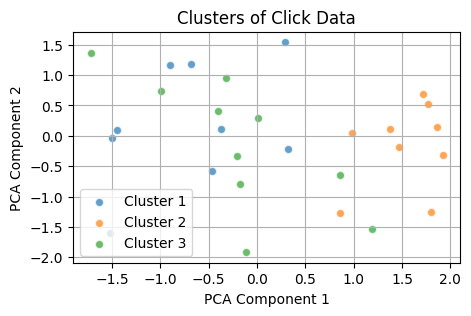

In [157]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

df = countries_df

scaler = StandardScaler()
click_data = df.iloc[:, 1:].values
click_data_normalized = scaler.fit_transform(click_data)

gmm = GaussianMixture(n_components=12, random_state=0)
gmm.fit(click_data_normalized)

log_likelihood = gmm.score(click_data_normalized)
bic = gmm.bic(click_data_normalized)
aic = gmm.aic(click_data_normalized)

print(f"Log-Likelihood: {log_likelihood}")
print(f"BIC: {bic}")
print(f"AIC: {aic}")

pca = PCA(n_components=2)
click_data_pca = pca.fit_transform(click_data_normalized)
cluster_labels = gmm.predict(click_data_normalized)

plt.figure(figsize=(5, 3))
for i in range(3):
    plt.scatter(click_data_pca[cluster_labels == i, 0], click_data_pca[cluster_labels == i, 1], label=f'Cluster {i+1}', alpha=0.7, edgecolors='w')

plt.title('Clusters of Click Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.show()